# COMPETIÇÃO
O objetivo deste trabalho passa por desenvolver modelos de Machine Learning capaz de prever o fluxo de tráfego rodoviário, numa determinada hora, no Porto.
O modelo a desenvolver terá, na sua base, o tempo que se demora a percorrer as ruas da cidade do Porto num determinado ponto temporal (record_date); na temperatura, pressão atmosférica, humidade, precipitação e velocidade do vento, entre outras, que caracterizam um determinado ponto temporal.
Devem utilizar o modelo desenvolvido para prever, para cada registo do dataset de teste, o nível de trânsito correspondente.


**Resumo:** A partir do dataset de treino modelar o average speed diff de um carro segundo as condições presente nos restantes dados. O average speed diff pode ser None, Low, Medium, High, Very_high isto é, pode não haver trânsito (None) até haver muito trânsito (Very_high). De seguida, aplicar a modelação para determinar quais os valores de average speed diff para cada linha do dataset de teste e enviar uma submissão para determinar a acurácia. 

**Problema supervisionado de classificação**

**Ficheiro**: Neste ficheiro apresentamos um tratamento de dados mais complexo com normalização e tratamento de outilers. Os outliers da coluna AVERAGE_TIME_DIFF que ultrapassavam de um determinado limite foram transformados na média dessa coluna. Também apresentamos um conjunto de modelos onde podemos ver a precisão aplicada ao dataset de treino e as previsões do dataset de teste.

## IMPORTS

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean, std
import sklearn
from sklearn import datasets
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
%matplotlib inline

## DATASET
O dataset de treino é constituido pelo os seguintes parâmetros:
- **city_name** - nome da cidade em causa;
- **record_date** - o timestamp associado ao registo;
- **average_speed_diff** - a diferença de velocidade corresponde à diferença entre (1.) a velocidade máxima que os carros podem atingir em cenários sem trânsito e (2.) a velocidade que realmente se verifica. Quanto mais alto o valor, maior é a diferença entre o que se está a andar no momento e o que se deveria estar a andar sem trânsito, i.e., valores altos deste atributo implicam que se está a andar mais devagar;
- **average_free_flow_speed** - o valor médio da velocidade máxima que os carros podem atingir em cenários sem trânsito;
- **average_time_diff** - o valor médio da diferença do tempo que se demora a percorrer um determinado conjunto de ruas. Quanto mais alto o valor maior é a diferença entre o tempo que demora para se percorrer as ruas e o que se deveria demorar sem trânsito, i.e., valores altos implicam que se está a demorar mais tempo a atravessar o conjunto de ruas;
- **average_free_flow_time** - o valor médio do tempo que demora a percorrer um determinado conjunto de ruas quando não há trânsito;
- **luminosity** - o nível de luminosidade que se verificava na cidade do Porto;
- **average_temperature** - o valor médio da temperatura para o record_date na cidade do Porto;
- **average_atmosp_pressure** - o valor médio da pressão atmosférica para o record_date;
- **average_humidity** - o valor médio da humidade para o record_date;
- **average_wind_speed** - o valor médio da velocidade do vento para o record_date;
- **average_cloudiness** - o valor médio da percentagem de nuvens para o record_date;
- **average_precipitation** - o valor médio de precipitação para o record_date;
- **average_rain** - avaliação qualitativa da precipitação para o record_date.

In [3]:
traffic = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [4]:
traffic

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_PRECIPITATION,AVERAGE_RAIN
0,Porto,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,NaN,0.0,NaN
1,Porto,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,céu claro,0.0,NaN
2,Porto,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,NaN,0.0,NaN
3,Porto,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,4.0,céu claro,0.0,NaN
4,Porto,2019-06-06 12:00:00,Medium,41.6,50.4,77.0,LIGHT,15.0,1008.0,82.0,10.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,Porto,2019-02-23 09:00:00,Low,41.2,3.7,86.9,LIGHT,9.0,1030.0,71.0,4.0,céu claro,0.0,NaN
6808,Porto,2019-06-08 18:00:00,Medium,38.9,51.9,76.9,LIGHT,17.0,1020.0,63.0,6.0,NaN,0.0,NaN
6809,Porto,2018-10-02 04:00:00,None,39.6,0.0,89.1,DARK,15.0,1020.0,39.0,4.0,céu claro,0.0,NaN
6810,Porto,2019-01-30 01:00:00,None,41.6,0.0,85.5,DARK,8.0,1018.0,81.0,1.0,algumas nuvens,0.0,NaN


In [5]:
# melhor representação dos dados atendendo aos outliers (moda media mediana)
# deteção de outliers (desvio padrão, vâriancia)
traffic.describe()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_PRECIPITATION
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.0
mean,40.661010,25.637111,81.143952,16.193482,1017.388139,80.084190,3.058573,0.0
std,4.119023,33.510507,8.294401,5.163492,5.751061,18.238863,2.138421,0.0
min,30.500000,0.000000,46.400000,0.000000,985.000000,14.000000,0.000000,0.0
25%,37.600000,2.275000,75.400000,13.000000,1015.000000,69.750000,1.000000,0.0
50%,40.700000,12.200000,82.400000,16.000000,1017.000000,83.000000,3.000000,0.0
75%,43.500000,36.200000,87.400000,19.000000,1021.000000,93.000000,4.000000,0.0
max,55.900000,296.500000,112.000000,35.000000,1033.000000,100.000000,14.000000,0.0


In [6]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city_name                6812 non-null   object 
 1   record_date              6812 non-null   object 
 2   AVERAGE_SPEED_DIFF       6812 non-null   object 
 3   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 4   AVERAGE_TIME_DIFF        6812 non-null   float64
 5   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 6   LUMINOSITY               6812 non-null   object 
 7   AVERAGE_TEMPERATURE      6812 non-null   float64
 8   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 9   AVERAGE_HUMIDITY         6812 non-null   float64
 10  AVERAGE_WIND_SPEED       6812 non-null   float64
 11  AVERAGE_CLOUDINESS       4130 non-null   object 
 12  AVERAGE_PRECIPITATION    6812 non-null   float64
 13  AVERAGE_RAIN             563 non-null    object 
dtypes: float64(8), object(6)

In [7]:
traffic['AVERAGE_SPEED_DIFF'].value_counts()

None         2200
Medium       1651
Low          1419
High         1063
Very_High     479
Name: AVERAGE_SPEED_DIFF, dtype: int64

In [8]:
traffic['LUMINOSITY'].value_counts()

LIGHT        3293
DARK         3253
LOW_LIGHT     266
Name: LUMINOSITY, dtype: int64

In [9]:
traffic['AVERAGE_CLOUDINESS'].value_counts()

céu claro            1582
céu pouco nublado     516
nuvens dispersas      459
nuvens quebrados      448
algumas nuvens        422
nuvens quebradas      416
céu limpo             153
tempo nublado          67
nublado                67
Name: AVERAGE_CLOUDINESS, dtype: int64

In [10]:
traffic['AVERAGE_RAIN'].value_counts()

chuva fraca                    261
chuva moderada                 153
chuva leve                      45
aguaceiros fracos               38
chuva                           30
aguaceiros                      11
chuva forte                      8
trovoada com chuva leve          7
chuvisco fraco                   5
chuva de intensidade pesado      2
chuva de intensidade pesada      1
trovoada com chuva               1
chuvisco e chuva fraca           1
Name: AVERAGE_RAIN, dtype: int64

In [11]:
print(traffic.isna().sum()) # Contagem dos valores em falta do dataset 

city_name                     0
record_date                   0
AVERAGE_SPEED_DIFF            0
AVERAGE_FREE_FLOW_SPEED       0
AVERAGE_TIME_DIFF             0
AVERAGE_FREE_FLOW_TIME        0
LUMINOSITY                    0
AVERAGE_TEMPERATURE           0
AVERAGE_ATMOSP_PRESSURE       0
AVERAGE_HUMIDITY              0
AVERAGE_WIND_SPEED            0
AVERAGE_CLOUDINESS         2682
AVERAGE_PRECIPITATION         0
AVERAGE_RAIN               6249
dtype: int64


In [12]:
print(traffic[traffic.duplicated()]) # Verifica se e quais são os valores duplicados

Empty DataFrame
Columns: [city_name, record_date, AVERAGE_SPEED_DIFF, AVERAGE_FREE_FLOW_SPEED, AVERAGE_TIME_DIFF, AVERAGE_FREE_FLOW_TIME, LUMINOSITY, AVERAGE_TEMPERATURE, AVERAGE_ATMOSP_PRESSURE, AVERAGE_HUMIDITY, AVERAGE_WIND_SPEED, AVERAGE_CLOUDINESS, AVERAGE_PRECIPITATION, AVERAGE_RAIN]
Index: []


## Vizualização dos dados

In [13]:
sns.set_theme(palette="pastel")

<AxesSubplot:>

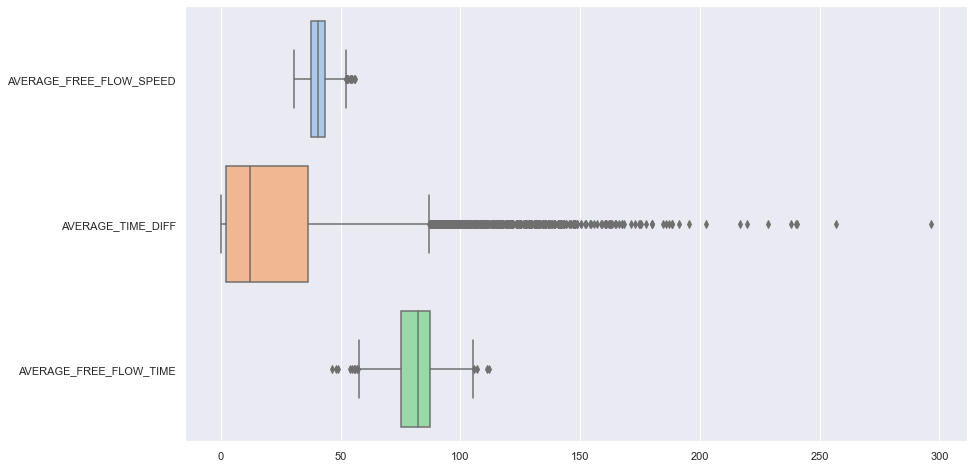

In [14]:
traffic_aux = traffic.drop(['city_name','record_date','AVERAGE_SPEED_DIFF','LUMINOSITY', 'AVERAGE_CLOUDINESS', 
                            'AVERAGE_RAIN', 'AVERAGE_PRECIPITATION', 'AVERAGE_TEMPERATURE', 'AVERAGE_ATMOSP_PRESSURE', 
                            'AVERAGE_HUMIDITY', 'AVERAGE_WIND_SPEED'], axis=1)
plt.subplots(figsize=(14,8))
sns.boxplot(data=traffic_aux, orient="h")

<AxesSubplot:xlabel='AVERAGE_SPEED_DIFF', ylabel='Count'>

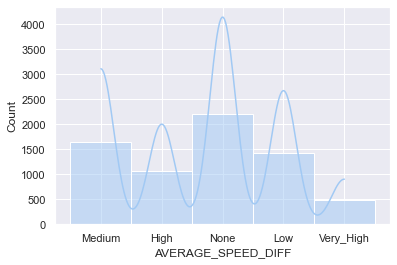

In [15]:
sns.histplot(traffic['AVERAGE_SPEED_DIFF'],kde=True)

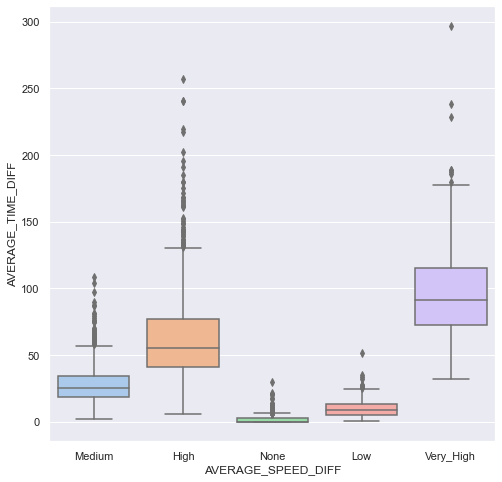

In [16]:
plt.subplots(figsize=(8,8))
ax = sns.boxplot(x=traffic["AVERAGE_SPEED_DIFF"], y=traffic["AVERAGE_TIME_DIFF"])

<AxesSubplot:>

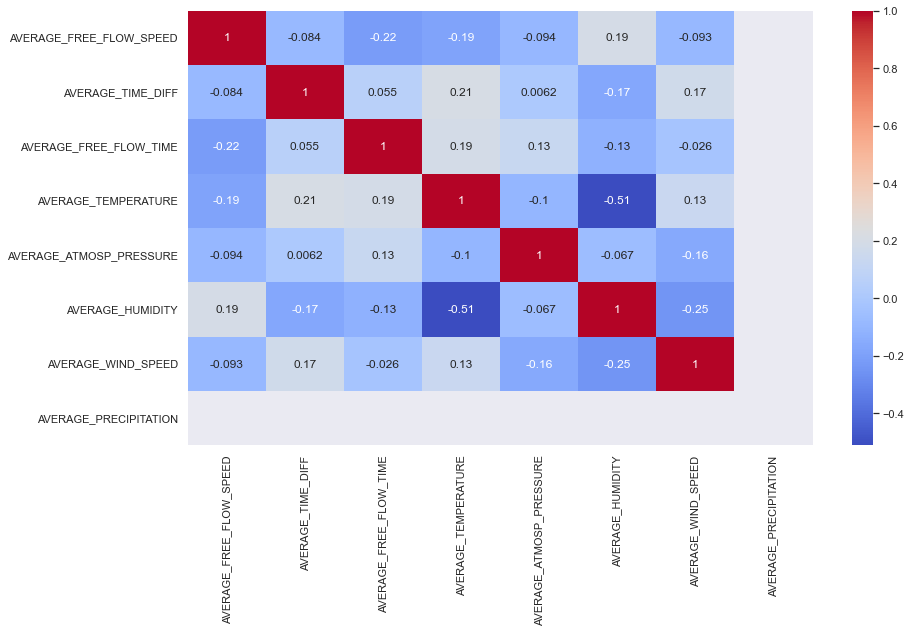

In [17]:
plt.subplots(figsize=(14,8))
sns.heatmap(traffic.corr(), annot = True, cmap='coolwarm')

## FASE 1
**Tratamento dos dados**

### Remoção de colunas redundantes
- *city_name*, *AVERAGE_PRECIPITATION* é sempre o mesmo em todas as obvervações
- *AVERAGE_CLOUDINESS*
- *AVERAGE_RAIN* tem muitas observações com *missing data* (6249), ia acrescentar muito ruído.
- *AVERAGE_HUMIDITY* tem uma correlação forte com a *AVERAGE_TEMPERATURE*, e por isso era redundante para o modelo de previsão.  

In [18]:
traffic = traffic.drop(['city_name'], axis=1)
traffic = traffic.drop(['AVERAGE_PRECIPITATION'], axis=1)
traffic = traffic.drop(['AVERAGE_CLOUDINESS'], axis=1)
traffic = traffic.drop(['AVERAGE_RAIN'], axis=1)
traffic = traffic.drop(['AVERAGE_HUMIDITY'], axis=1)

test = test.drop(['city_name'], axis=1)
test = test.drop(['AVERAGE_PRECIPITATION'], axis=1)
test = test.drop(['AVERAGE_CLOUDINESS'], axis=1)
test = test.drop(['AVERAGE_RAIN'], axis=1)
test = test.drop(['AVERAGE_HUMIDITY'], axis=1)

### Transformação de valores categóricos
- O *AVERAGE_SPEED_DIFF* devemos passar para do tipo int (None = 0, Low = 1, Medium = 2, High = 3, Very_High = 4)
- a *LUMINOSITY* pode ser passada para o tipo int (Dark = 0, Low_Light = 1, Light = 2)
- *AVERAGE_CLOUDINESS* 


In [19]:
#tratamento de average_speed_diff, luminosity

traffic["AVERAGE_SPEED_DIFF"] = traffic['AVERAGE_SPEED_DIFF'].replace({'None' : 0, 'Low' : 1, 'Medium' : 2, 'High' : 3, 'Very_High' : 4}).astype(int)
traffic["LUMINOSITY"] = traffic['LUMINOSITY'].replace({'DARK' : 0, 'LOW_LIGHT' : 1, 'LIGHT' : 2}).astype(int)

test["LUMINOSITY"] = test['LUMINOSITY'].replace({'DARK' : 0, 'LOW_LIGHT' : 1, 'LIGHT' : 2}).astype(int)

In [20]:
# tratamento realizado onde transformados os dados categóricos das colunas AVERAGE_RAIN e AVERAGE_CLOUDINESS em valores numéricos
'''
traffic["AVERAGE_CLOUDINESS"] = traffic["AVERAGE_CLOUDINESS"].replace({'céu claro' : 0, 'céu pouco nublado' : 1, 'nuvens dispersas' : 1, 'nuvens quebrados' : 1, 'algumas nuvens' : 1, 'nuvens quebradas' : 1, 
                                                                       'céu limpo' : 0, 'tempo nublado' : 2, 'nublado' : 2})
test["AVERAGE_CLOUDINESS"] = test["AVERAGE_CLOUDINESS"].replace({'céu claro' : 0, 'céu pouco nublado' : 1, 'nuvens dispersas' : 1, 'nuvens quebrados' : 1, 'algumas nuvens' : 1, 'nuvens quebradas' : 1, 
                                                                       'céu limpo' : 0, 'tempo nublado' : 2, 'nublado' : 2})

traffic["AVERAGE_RAIN"] = traffic["AVERAGE_RAIN"].replace(np.nan, '')
traffic["AVERAGE_RAIN"] = traffic["AVERAGE_RAIN"].replace({'chuva fraca' : 0, 'chuva leve' : 0, 'chuvisco fraco' : 0, 'chuvisco e chuva fraca' : 0, 'aguaceiros fracos' : 0, 'trovoada com chuva leve' : 0,
                                                           'chuva' : 1, 'chuva moderada' : 1, 'aguaceiros' : 1, 'trovoada com chuva' : 1, 'chuva forte' : 2, 'chuva de intensidade pesado' : 2,
                                                           'chuva de intensidade pesada' : 2})


#traffic["AVERAGE_CLOUDINESS"] = traffic["AVERAGE_CLOUDINESS"].replace(np.nan, 1)
#test["AVERAGE_CLOUDINESS"] = test["AVERAGE_CLOUDINESS"].replace(np.nan, 1)
'''

'\ntraffic["AVERAGE_CLOUDINESS"] = traffic["AVERAGE_CLOUDINESS"].replace({\'céu claro\' : 0, \'céu pouco nublado\' : 1, \'nuvens dispersas\' : 1, \'nuvens quebrados\' : 1, \'algumas nuvens\' : 1, \'nuvens quebradas\' : 1, \n                                                                       \'céu limpo\' : 0, \'tempo nublado\' : 2, \'nublado\' : 2})\ntest["AVERAGE_CLOUDINESS"] = test["AVERAGE_CLOUDINESS"].replace({\'céu claro\' : 0, \'céu pouco nublado\' : 1, \'nuvens dispersas\' : 1, \'nuvens quebrados\' : 1, \'algumas nuvens\' : 1, \'nuvens quebradas\' : 1, \n                                                                       \'céu limpo\' : 0, \'tempo nublado\' : 2, \'nublado\' : 2})\n\ntraffic["AVERAGE_RAIN"] = traffic["AVERAGE_RAIN"].replace(np.nan, \'\')\ntraffic["AVERAGE_RAIN"] = traffic["AVERAGE_RAIN"].replace({\'chuva fraca\' : 0, \'chuva leve\' : 0, \'chuvisco fraco\' : 0, \'chuvisco e chuva fraca\' : 0, \'aguaceiros fracos\' : 0, \'trovoada com chuva leve\' : 0,\n     

### Criação de Features - Data da observação
- o record_date pode ser dividido em 3 colunas - hora, dia da semana e mes. 
    - O dia da semana é posteriormente transformado em números entre 0-6.

In [21]:
#transformação da data para datetime
traffic.record_date = pd.to_datetime(traffic.record_date)

test.record_date = pd.to_datetime(test.record_date)

In [22]:
#divisão da coluna record_date em 3 colunas diferentes
traffic['Month'] = traffic.record_date.dt.month
traffic['Hour'] = traffic.record_date.dt.hour
traffic['Day'] = traffic.record_date.dt.day_name()
traffic['Day'] = traffic['Day'].replace({'Sunday' : 1, 'Monday' : 2, 'Tuesday' : 3, 'Wednesday' : 4, 'Thursday' : 5,'Friday' : 6,'Saturday' : 7}).astype(int)
traffic = traffic.drop(['record_date'], axis=1)

test['Month'] = test.record_date.dt.month
test['Hour'] = test.record_date.dt.hour
test['Day'] = test.record_date.dt.day_name()
test['Day'] = test['Day'].replace({'Sunday' : 1, 'Monday' : 2, 'Tuesday' : 3, 'Wednesday' : 4, 'Thursday' : 5,'Friday' : 6,'Saturday' : 7}).astype(int)
test = test.drop(['record_date'], axis=1)

### Tratamento dos *outliers*

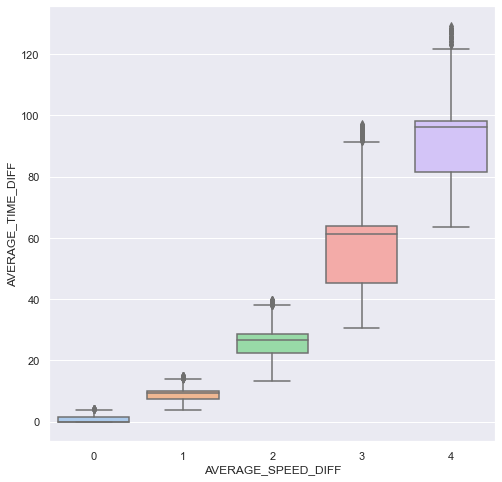

In [23]:
# substitui os outliers pela média
def replace(group):
    mean, std = group.mean(), group.std()
    outliers = (group - mean).abs() > 1*std
    group[outliers] = mean        # or "group[~outliers].mean()"
    return group

traffic['AVERAGE_TIME_DIFF'] = traffic.groupby('AVERAGE_SPEED_DIFF')['AVERAGE_TIME_DIFF'].transform(replace)
plt.subplots(figsize=(8,8))
ax = sns.boxplot(x=traffic["AVERAGE_SPEED_DIFF"], y=traffic["AVERAGE_TIME_DIFF"])

### Normalização dos dados
- normalização dos dados numéricos para que estes fiquem entre 0 e 1
- utilizar o *get_dummies* para obter os dados categóricos dividios entre colunas.

In [24]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
traffic[['AVERAGE_FREE_FLOW_SPEED']] = min_max_scaler.fit_transform(traffic[['AVERAGE_FREE_FLOW_SPEED']])
traffic[['AVERAGE_TIME_DIFF']] = min_max_scaler.fit_transform(traffic[['AVERAGE_TIME_DIFF']])
traffic[['AVERAGE_FREE_FLOW_TIME']] = min_max_scaler.fit_transform(traffic[['AVERAGE_FREE_FLOW_TIME']])
traffic['AVERAGE_TEMPERATURE'] = min_max_scaler.fit_transform(traffic[['AVERAGE_TEMPERATURE']])
traffic[["AVERAGE_ATMOSP_PRESSURE"]] = min_max_scaler.fit_transform(traffic[["AVERAGE_ATMOSP_PRESSURE"]])
traffic[["AVERAGE_WIND_SPEED"]] = min_max_scaler.fit_transform(traffic[["AVERAGE_WIND_SPEED"]])
traffic[["Hour"]] = min_max_scaler.fit_transform(traffic[["Hour"]])
traffic[["Month"]] = min_max_scaler.fit_transform(traffic[["Month"]])

test[['AVERAGE_FREE_FLOW_SPEED']] = min_max_scaler.fit_transform(test[['AVERAGE_FREE_FLOW_SPEED']])
test[['AVERAGE_TIME_DIFF']] = min_max_scaler.fit_transform(test[['AVERAGE_TIME_DIFF']])
test[['AVERAGE_FREE_FLOW_TIME']] = min_max_scaler.fit_transform(test[['AVERAGE_FREE_FLOW_TIME']])
test['AVERAGE_TEMPERATURE'] = min_max_scaler.fit_transform(test[['AVERAGE_TEMPERATURE']])
test[["AVERAGE_ATMOSP_PRESSURE"]] = min_max_scaler.fit_transform(test[["AVERAGE_ATMOSP_PRESSURE"]])
test[["AVERAGE_WIND_SPEED"]] = min_max_scaler.fit_transform(test[["AVERAGE_WIND_SPEED"]])
test[["Hour"]] = min_max_scaler.fit_transform(test[["Hour"]])
test[["Month"]] = min_max_scaler.fit_transform(test[["Month"]])

In [25]:
traffic_aux = traffic.drop(['AVERAGE_SPEED_DIFF'], axis=1)
traffic_aux = pd.get_dummies(traffic_aux, drop_first = True)
traffic = pd.concat([traffic['AVERAGE_SPEED_DIFF'], traffic_aux], axis=1)

test = pd.get_dummies(test, drop_first = True)

### Dataset Final

<AxesSubplot:>

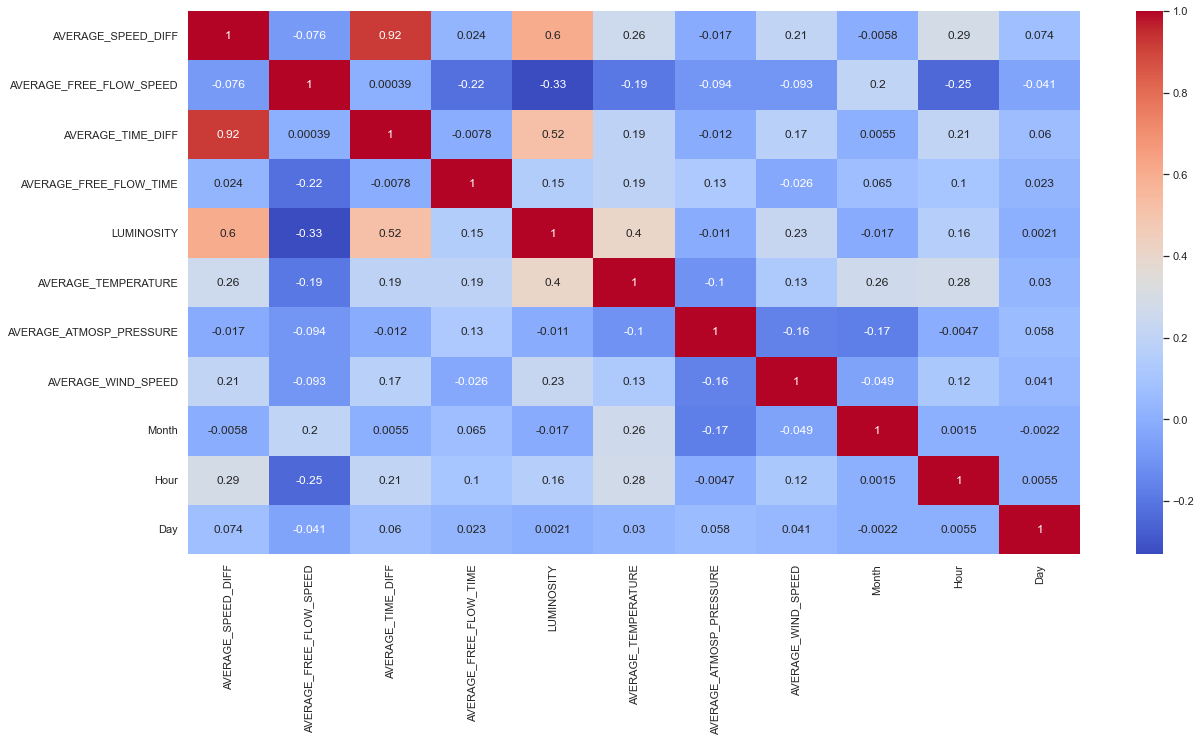

In [26]:
#matriz de correlação
plt.subplots(figsize=(20,10))
sns.heatmap(traffic.corr(), annot = True, cmap='coolwarm')

In [27]:
test

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_WIND_SPEED,Month,Hour,Day
0,0.325397,0.000000,0.739655,0,0.225806,0.854167,0.076923,0.090909,1.000000,4
1,0.456349,0.052518,0.494828,0,0.322581,0.729167,0.307692,0.909091,0.869565,4
2,0.591270,0.000000,0.658621,0,0.419355,0.666667,0.000000,0.636364,0.217391,3
3,0.087302,0.222557,0.720690,2,0.677419,0.645833,0.307692,0.545455,0.739130,7
4,0.515873,0.015067,0.644828,0,0.354839,0.395833,0.692308,0.818182,0.260870,2
...,...,...,...,...,...,...,...,...,...,...
1495,0.761905,0.004735,0.558621,0,0.322581,0.583333,0.384615,0.909091,0.217391,7
1496,0.277778,0.019802,0.646552,0,0.258065,0.895833,0.000000,0.181818,0.086957,6
1497,0.507937,0.000000,0.556897,0,0.483871,0.583333,0.076923,0.727273,0.043478,4
1498,0.595238,0.358158,0.605172,2,0.290323,0.395833,0.384615,0.909091,0.347826,2


## FASE 2
**Criação do modelo**

In [28]:
#divisão do target
x = traffic.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y = traffic['AVERAGE_SPEED_DIFF']

In [29]:
x

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_WIND_SPEED,Month,Hour,Day
0,0.433071,0.206465,0.381098,2,0.428571,0.708333,0.214286,0.636364,0.304348,5
1,0.440945,0.374129,0.625000,2,0.600000,0.750000,0.357143,0.636364,0.608696,6
2,0.318898,0.297444,0.591463,2,0.742857,0.604167,0.285714,0.727273,0.695652,1
3,0.271654,0.472502,0.727134,2,0.514286,0.833333,0.285714,0.090909,0.478261,3
4,0.437008,0.206465,0.466463,2,0.428571,0.479167,0.714286,0.454545,0.521739,5
...,...,...,...,...,...,...,...,...,...,...
6807,0.421260,0.028660,0.617378,2,0.257143,0.937500,0.285714,0.090909,0.391304,7
6808,0.330709,0.206465,0.464939,2,0.485714,0.729167,0.428571,0.454545,0.782609,7
6809,0.358268,0.000000,0.650915,0,0.428571,0.729167,0.285714,0.818182,0.173913,3
6810,0.437008,0.000000,0.596037,0,0.228571,0.687500,0.071429,0.000000,0.043478,4


In [30]:
y

0       2
1       3
2       3
3       3
4       2
       ..
6807    1
6808    2
6809    0
6810    0
6811    2
Name: AVERAGE_SPEED_DIFF, Length: 6812, dtype: int32

### MODELOS

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.25, random_state=2021)

In [32]:
#criação de uma arvore de decião 73%
print("**DecisionTreeClassifier**")
clf_Tree = DecisionTreeClassifier(random_state=2021)
clf_Tree.fit(x,y)

print("Test Data...")
predictions_Tree = clf_Tree.predict(test)
print(predictions_Tree)

#k cross val
print("Training Data...")
scores = cross_val_score(clf_Tree,x,y,cv = 10)
print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

**DecisionTreeClassifier**
Test Data...
[0 1 0 ... 0 3 1]
Training Data...
Cross Validation Accuracy: 0.9508 (+/- 0.0193)


In [33]:
#criação de uma arvore de decisão 84,7%
print("**RandomForestClassifier**")
clf_Forest = RandomForestClassifier(n_estimators=100, random_state=2021)
clf_Forest.fit(x,y)

print("Test Data...")
predictions_Forest = clf_Forest.predict(test)
print(predictions_Forest)

print("Training Data...")
scores = cross_val_score(clf_Forest,x,y,cv = 10)
print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

**RandomForestClassifier**
Test Data...
[0 1 0 ... 0 3 1]
Training Data...
Cross Validation Accuracy: 0.9576 (+/- 0.0243)


In [34]:
#criação de uma arvore de decisão 84,7%
print("**RandomForestClassifier**")
clf_Forest2 = RandomForestClassifier(n_estimators=500, random_state=2021, criterion='entropy')
clf_Forest2.fit(x,y)

print("Test Data...")
predictions_Forest2 = clf_Forest2.predict(test)
print(predictions_Forest2)

print("Training Data...")
scores = cross_val_score(clf_Forest2,x,y,cv = 10)
print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))


**RandomForestClassifier**
Test Data...
[0 1 0 ... 0 3 1]
Training Data...
Cross Validation Accuracy: 0.9601 (+/- 0.0191)


In [35]:
print("**AdaBoostClassifier**")
base = RandomForestClassifier(n_estimators=500, random_state=2021, criterion='entropy')
clf_Booster = AdaBoostClassifier(n_estimators=100, random_state=2021, base_estimator=base)
clf_Booster.fit(x,y)

print("Test Data...")
predictions_Booster = clf_Booster.predict(test)
print(predictions_Booster)

#k cross val
print("Training Data...")
scores = cross_val_score(clf_Booster,x,y,cv = 10)
print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

**AdaBoostClassifier**
Test Data...
[0 1 0 ... 0 3 1]
Training Data...
Cross Validation Accuracy: 0.9607 (+/- 0.0201)


In [36]:
print("**BaggingClassifier**")
clf_BG = BaggingClassifier(KNeighborsClassifier(), random_state=2021, max_samples=0.5, max_features=0.5)
clf_BG.fit(x,y)

print("Test Data...")
predictions_BG = clf_BG.predict(test)
print(predictions_BG)

#k cross val
print("Training Data...")
scores = cross_val_score(clf_BG,x,y,cv = 10)
print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

**BaggingClassifier**
Test Data...
[0 0 0 ... 0 3 1]
Training Data...
Cross Validation Accuracy: 0.7945 (+/- 0.0225)


In [37]:
print("**Voting Classifier**")
# clf1 = DecisionTreeClassifier(random_state=2021)
# clf2 = RandomForestClassifier(n_estimators=100, random_state=2021, criterion='entropy')
# clf3 = BaggingClassifier(KNeighborsClassifier(), random_state=2021, max_samples=0.5, max_features=0.5)
# clf4 = AdaBoostClassifier(n_estimators=100, random_state=2021, base_estimator=base)
clf5 = LogisticRegression(random_state=1)
clf6 = GaussianNB()

eclf = VotingClassifier(
     estimators=[('DecisionTree', clf_Tree), ('RandomForest', clf_Forest2), ('bag', clf_BG), 
                 ('boost', clf_Booster), ('lr', clf5), ('gnb', clf6)],
     voting='hard')

#evaluate the test dataset
#test_p = eclf.predict(X_test)
#test_acc = accuracy_score(Y_test,test_p)

for clf, label in zip( [clf_Tree, clf_Forest2, clf_BG, clf_Booster, clf5, clf6, eclf], ['Decision Tree', 
     'Random Forest', 'Bagging', 'Boosting', 'Logistic Regression', 'naive Bayes', 'Voting Ensemble']):
     scores = cross_val_score(clf, x, y, scoring='accuracy', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))




**Voting Classifier**
Accuracy: 0.95 (+/- 0.01) [Decision Tree]
Accuracy: 0.96 (+/- 0.01) [Random Forest]
Accuracy: 0.78 (+/- 0.02) [Bagging]
Accuracy: 0.96 (+/- 0.01) [Boosting]


C:\Anaconda\anaconda3\envs\DAA\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\anaconda3\envs\DAA\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Accuracy: 0.82 (+/- 0.01) [Logistic Regression]
Accuracy: 0.93 (+/- 0.01) [naive Bayes]


C:\Anaconda\anaconda3\envs\DAA\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\anaconda3\envs\DAA\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Accuracy: 0.95 (+/- 0.01) [Voting Ensemble]


In [38]:
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=2021)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
space['criterion'] = ['gini', 'entropy']
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)

result = search.fit(x,y)
best_model = result.best_estimator_
predictions= best_model.predict(test)
# configure the cross-validation procedure
#predictions_final  = pd.DataFrame(predictions, columns = ["Speed_Diff"])
#print(predictions_final)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, x, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.960 (0.005)


## FASE 3
**Passagem dos valores para ficheiro CSV**

In [39]:
'''
# acrescentar headers
submission = pd.DataFrame(predictions_Booster, columns = ["Speed_Diff"])
submission.insert(0, "RowId", range(1,1501), True)

#transformação dos valores para formato escrito
submission['Speed_Diff']= submission['Speed_Diff'].replace({0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'})

#passagem para ficheiro csv
submission.to_csv('Sub9_BoostOutlierReplace.csv', index=False)

submission'''

'\n# acrescentar headers\nsubmission = pd.DataFrame(predictions_Booster, columns = ["Speed_Diff"])\nsubmission.insert(0, "RowId", range(1,1501), True)\n\n#transformação dos valores para formato escrito\nsubmission[\'Speed_Diff\']= submission[\'Speed_Diff\'].replace({0 : \'None\', 1 : \'Low\', 2 : \'Medium\', 3 : \'High\', 4 : \'Very_High\'})\n\n#passagem para ficheiro csv\nsubmission.to_csv(\'Sub9_BoostOutlierReplace.csv\', index=False)\n\nsubmission'

## EXTRA

### Features mais importantes

In [40]:
'''
feat = list(traffic)
for feature in zip(feat, clf_Forest.feature_importances_):
    print(feature)
'''

'\nfeat = list(traffic)\nfor feature in zip(feat, clf_Forest.feature_importances_):\n    print(feature)\n'